# ライブラリ

In [1]:
import numpy as np
import pandas as pd

# 問1 ----------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# 問2 ----------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# VIF
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Optuna
import optuna

# Dataset の用意

## Dataset の作成 (最初の1度のみでよい)

In [2]:
data_list = []
with open("/home/nakaya-shunsuke/covtype.data", "r") as f:
    for i, line in enumerate(f):
        list_line = line.strip().split(",")
        data_list.append(list_line)

# dfへの変換とcolumnsの追加
data_df = pd.DataFrame(data_list)
columns = ["Elevation", "Aspect", "Slope", "HorizontalDistanceToHydrology", "VerticalDistanceToHydrology", "HorizontalDistanceToRoadways", "Hillshade9am", "HillshadeNoon", "Hillshade3pm", "HorizontalDistanceToFirePoints"]

for i in range(1, 4+1):
    wilderness = f"WildernessArea{i}"
    columns.append(wilderness)
    
for j in range(1, 40+1):
    soil = f"SoilType{j}"
    columns.append(soil)

columns.append("CoverType")
data_df.columns = columns

# Datasetの.csv
data_df.to_csv("/home/nakaya-shunsuke/covtype.csv", index=False)
# 説明変数データの.csv
data_df[columns[:-1]].to_csv("/home/nakaya-shunsuke/covtype_input.csv", index=False)
# 目的変数データの.csv
data_df[columns[-1]].to_csv("/home/nakaya-shunsuke/covtype_target.csv", index=False)

## Dataset のロード

In [2]:
# Dataset の load
df_input = pd.read_csv("/home/nakaya-shunsuke/CA-Tech-Lounge-Dataset/covtype_input.csv")
df_target = pd.read_csv("/home/nakaya-shunsuke/CA-Tech-Lounge-Dataset/covtype_target.csv")

## 欠損値の確認

In [3]:
df_input.isnull().sum()

Elevation                         0
Aspect                            0
Slope                             0
HorizontalDistanceToHydrology     0
VerticalDistanceToHydrology       0
HorizontalDistanceToRoadways      0
Hillshade9am                      0
HillshadeNoon                     0
Hillshade3pm                      0
HorizontalDistanceToFirePoints    0
WildernessArea1                   0
WildernessArea2                   0
WildernessArea3                   0
WildernessArea4                   0
SoilType1                         0
SoilType2                         0
SoilType3                         0
SoilType4                         0
SoilType5                         0
SoilType6                         0
SoilType7                         0
SoilType8                         0
SoilType9                         0
SoilType10                        0
SoilType11                        0
SoilType12                        0
SoilType13                        0
SoilType14                  

## Train, Valid, Test の分割

In [3]:
df_input_train = df_input.iloc[:11340]
df_target_train = df_target.iloc[:11340]
np_input_train = np.array(df_input_train)
np_target_train = np.array(df_target_train).reshape(-1)

df_input_valid = df_input.iloc[11340:11340+3780]
df_target_valid = df_target.iloc[11340:11340+3780]
np_input_valid = np.array(df_input_valid)
np_target_valid = np.array(df_target_valid).reshape(-1)

df_input_test = df_input.iloc[11340+3780:]
df_target_test = df_target.iloc[11340+3780:]
np_input_test = np.array(df_input_test)
np_target_test = np.array(df_target_test).reshape(-1)

# 問1

In [4]:
n_split = 5
shuffle = True
random_state = 42

In [6]:
# Ramdom Forestを工夫なしで適用
rfc = RandomForestClassifier(random_state=42)
rfc.fit(np_input_train, np_target_train)
scores = rfc.score(np_input_valid, np_target_valid)

print(f"score : {scores}")

score : 0.8505291005291006


In [7]:
# Random Forest の特徴量重要度
f_imp = rfc.feature_importances_

f_imps = {}
print(f"Feature Importances : ")

for i, f in enumerate(df_input.columns):
    f_imps[f] = f_imp[i]
    
sorted_f_imps = (sorted(f_imps.items(), key=lambda f : -f[1]))
print(sorted_f_imps)

Feature Importances : 
[('Elevation', 0.21754022754167185), ('HorizontalDistanceToRoadways', 0.0977263383904659), ('HorizontalDistanceToFirePoints', 0.07297438194535784), ('HorizontalDistanceToHydrology', 0.06638651035438146), ('Hillshade9am', 0.05334374241463062), ('VerticalDistanceToHydrology', 0.05255369394710918), ('Aspect', 0.049586157529833794), ('Hillshade3pm', 0.046678060910083925), ('HillshadeNoon', 0.045995306794989234), ('Slope', 0.0368622493906581), ('WildernessArea4', 0.03535807189615591), ('SoilType10', 0.022642176912186757), ('SoilType3', 0.022299783012487393), ('WildernessArea1', 0.021337530788766153), ('WildernessArea3', 0.01883710248178462), ('SoilType39', 0.018179385579137917), ('SoilType38', 0.016488482187320484), ('SoilType4', 0.012836347158312396), ('SoilType40', 0.009804965766511974), ('SoilType30', 0.008425077691119743), ('SoilType13', 0.006746166155159997), ('SoilType2', 0.006307157767005845), ('SoilType32', 0.005484944118263807), ('SoilType23', 0.0053109259121

## Cross Validation

In [8]:
_, c_train = np.unique(np_target_train, return_counts=True)
_, c_valid = np.unique(np_target_valid, return_counts=True)
_, c_test = np.unique(np_target_test, return_counts=True)

print(f"N each label (1 ~ 7) : \n train : {c_train}\n valid : {c_valid}\n test : {c_test}")

N each label (1 ~ 7) : 
 train : [1620 1620 1620 1620 1620 1620 1620]
 valid : [540 540 540 540 540 540 540]
 test : [209680 281141  33594    587   7333  15207  18350]


- 上のようにTrain, Valid では, 各ラベル(1 ~ 7)の数が同じになっている.

- 一方で, Testでは各ラベルの数に偏りがあるため Cross Validation の方法として以下の2つを評価方法が考えられる.
     1. Testには各ラベルの数に偏りがあるが, 偏りを作るために意図的にKFold(shuffle=True) を用いて Cross Validation を行うとデータリークに該当する可能性があるので, 通常どおりStratifiedKFold(shuffle=True) を用いてCross Validationを行う.
     2. そもそもの問題設定として, Train, Valid, Test の合計5810112データを先にshuffleした後に Train, Valid, Testに分割し, Train に対してStratifiedKFold(shuffle=True)を用いて Cross Validation を行う. <br> <追記>宝田さんに質問したところ, Train, Valid, Testの各々のデータ数の指定はないとのことだったので, どちらの評価方法も可能.


- まずは 1. を評価方法として問を進める. その後, 時間があれば 2. を評価方法として同様に問に取り組む.

In [114]:
rfc = RandomForestClassifier(random_state=42)

k_fold = KFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)

k_fold_scores = cross_val_score(rfc, np_input_train, np_target_train, cv=k_fold)
sk_fold_scores = cross_val_score(rfc, np_input_train, np_target_train, cv=sk_fold)

print(f"KFold Cross Val Score : {k_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(k_fold_scores)}")
print("----------------------------------------------------------------------------")
print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

KFold Cross Val Score : [0.8633157  0.85361552 0.85537919 0.83906526 0.84347443]
Mean Cross Val Score : 0.8509700176366843
----------------------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.86507937 0.84391534 0.85361552 0.85097002 0.84435626]
Mean Cross Val Score : 0.8515873015873016


## 結果と考察

- 結果
    - ベースラインモデルとして, データ分析でよく用いられる Random Forest を用いた.
    - 問1では特徴量エンジニアリングなどはしていない.
    - StratifiedKFold Cross Validation(以後 CV) を行ったところ平均スコアは0.5713であった.
    - なお, このCVは 11,340データの Train データのみを用いて行った.
    - Feature Importance は現状, 以下の順である.
        - Elevation
        - HorizontalDistanceToRoadways
        - HorizontalDistanceToFirePoints
    
- 考察
    - 予測精度を向上させるための工夫として次が挙げられる.
        - データ正規化
        - 特徴量エンジニアリング
        - モデルの選択
            - 決定木系
            - ロジスティック回帰
            - SVM
            - KNN
            - Neural Net
        - ハイパーパラメータチューニング
    - FIが信頼できるものなのか, 説明変数の分析をする必要がある.

# 問2

## モデルの選択

In [6]:
print(f"Random Forest ------------------------------------------------------------")

rfc = RandomForestClassifier(random_state=42)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(rfc, np_input_train, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

# 収束せず
# print(f"Logistic Regression ------------------------------------------------------------")

# lgr = LogisticRegression(random_state=random_state)

# sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
# sk_fold_scores = cross_val_score(lgr, np_input_train, np_target_train, cv=sk_fold)

# print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
# print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"SVM ------------------------------------------------------------")

svc = SVC(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(svc, np_input_train, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"KNN ------------------------------------------------------------")

knn = KNeighborsClassifier()

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(knn, np_input_train, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"MLP ------------------------------------------------------------")

mlp = MLPClassifier(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(mlp, np_input_train, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

Random Forest ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.86507937 0.84391534 0.8505291  0.85670194 0.84744268]
Mean Cross Val Score : 0.8527336860670195
SVM ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.64638448 0.62345679 0.62610229 0.62257496 0.62742504]
Mean Cross Val Score : 0.6291887125220459
KNN ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.79232804 0.79232804 0.78439153 0.77248677 0.77910053]
Mean Cross Val Score : 0.7841269841269842
MLP ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.52513228 0.63227513 0.48677249 0.57231041 0.52513228]
Mean Cross Val Score : 0.5483245149911816


## 説明変数分析(量的変数)

In [8]:
df_input_train_qv = df_input_train.iloc[:, :10]
df_input_valid_qv = df_input_valid.iloc[:, :10]
np_input_train_qv = np.array(df_input_train_qv)
np_input_valid_qv = np.array(df_input_valid_qv)

In [9]:
print(f"Random Forest ------------------------------------------------------------")

rfc = RandomForestClassifier(random_state=42)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(rfc, np_input_train_qv, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

# 収束せず
# print(f"Logistic Regression ------------------------------------------------------------")

# lgr = LogisticRegression(random_state=random_state)

# sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
# sk_fold_scores = cross_val_score(lgr, np_input_train_qv, np_target_train, cv=sk_fold)

# print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
# print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"SVM ------------------------------------------------------------")

svc = SVC(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(svc, np_input_train_qv, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"KNN ------------------------------------------------------------")

knn = KNeighborsClassifier()

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(knn, np_input_train_qv, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"MLP ------------------------------------------------------------")

mlp = MLPClassifier(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(mlp, np_input_train_qv, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

Random Forest ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.82363316 0.82716049 0.83289242 0.82231041 0.82583774]
Mean Cross Val Score : 0.8263668430335096
SVM ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.65079365 0.62830688 0.63580247 0.62786596 0.63536155]
Mean Cross Val Score : 0.635626102292769
KNN ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.79232804 0.79232804 0.78439153 0.77248677 0.77910053]
Mean Cross Val Score : 0.7841269841269842
MLP ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.56922399 0.47530864 0.49955908 0.54100529 0.55864198]
Mean Cross Val Score : 0.5287477954144622


## 正規化

In [10]:
def norm_minmax(df, df_min=None, df_max=None):
    if df_min is None or df_max is None:
        df_min = df.min()
        df_max = df.max()
        
    return (df - df_min) / (df_max - df_min)

df_input_train_qv_norm = norm_minmax(df_input_train_qv)
np_input_train_qv_norm = np.array(df_input_train_qv_norm)

In [11]:
print(f"Random Forest ------------------------------------------------------------")

rfc = RandomForestClassifier(random_state=42)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(rfc, np_input_train_qv_norm, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

# # 収束せず
# print(f"Logistic Regression ------------------------------------------------------------")

# lgr = LogisticRegression(random_state=random_state)

# sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
# sk_fold_scores = cross_val_score(lgr, np_input_train_qv, np_target_train, cv=sk_fold)

# print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
# print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"SVM ------------------------------------------------------------")

svc = SVC(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(svc, np_input_train_qv_norm, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"KNN ------------------------------------------------------------")

knn = KNeighborsClassifier()

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(knn, np_input_train_qv_norm, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"MLP ------------------------------------------------------------")

mlp = MLPClassifier(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(mlp, np_input_train_qv_norm, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

Random Forest ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.82319224 0.82760141 0.83156966 0.82186949 0.82539683]
Mean Cross Val Score : 0.8259259259259257
SVM ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.71560847 0.7037037  0.70634921 0.70149912 0.7037037 ]
Mean Cross Val Score : 0.7061728395061728
KNN ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.75132275 0.74294533 0.73897707 0.73148148 0.73985891]
Mean Cross Val Score : 0.7409171075837742
MLP ------------------------------------------------------------


/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

StratifiedKFold Cross Val Score : [0.7164903  0.70149912 0.68871252 0.71031746 0.71031746]
Mean Cross Val Score : 0.7054673721340389


/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 外れ値検出

Elevation : 
N of Min outer : 0
N of Max outer : 0


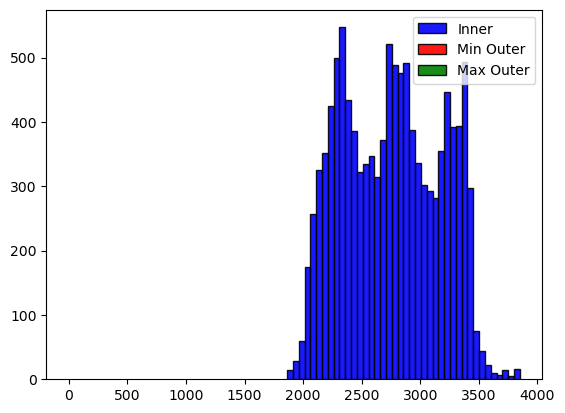

---------------------------------------------------------------------------------------------------
Aspect : 
N of Min outer : 0
N of Max outer : 0


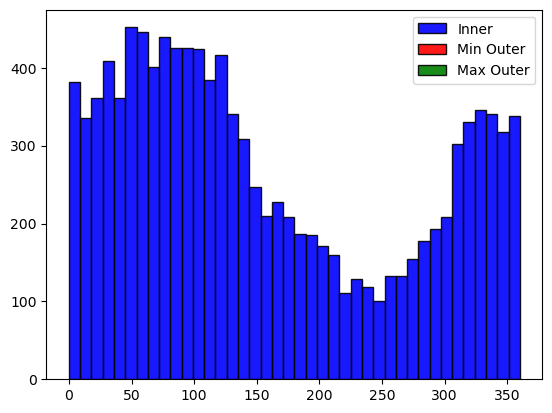

---------------------------------------------------------------------------------------------------
Slope : 
N of Min outer : 0
N of Max outer : 46


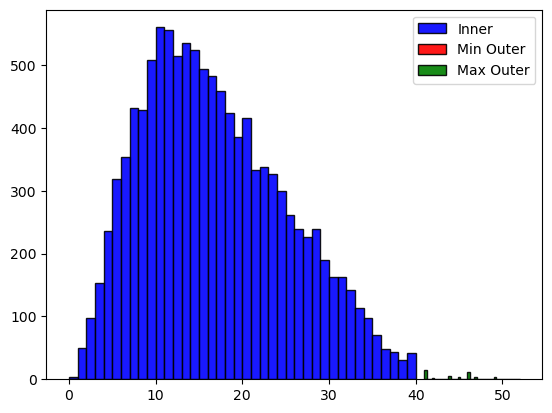

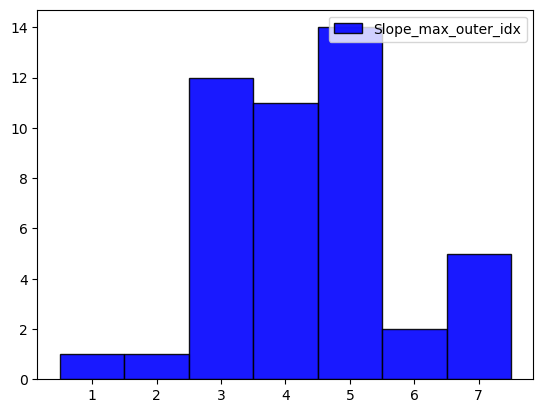

---------------------------------------------------------------------------------------------------
HorizontalDistanceToHydrology : 
N of Min outer : 0
N of Max outer : 381


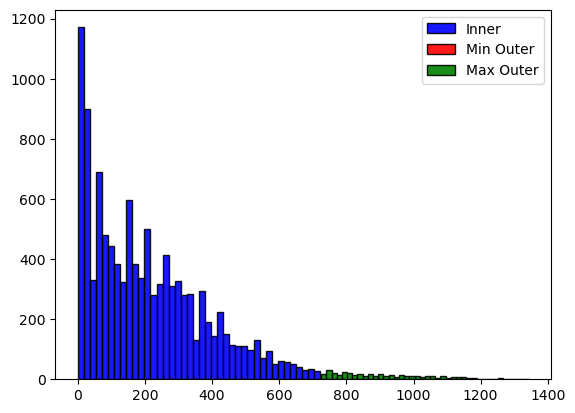

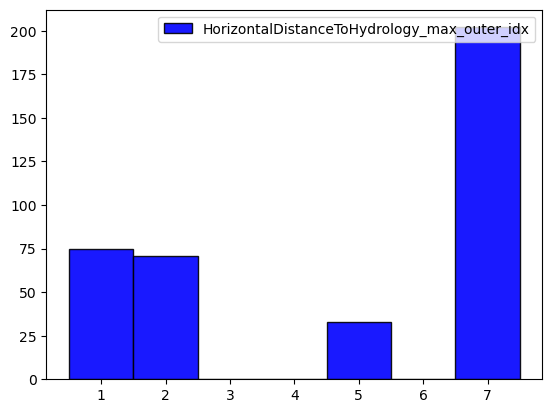

---------------------------------------------------------------------------------------------------
VerticalDistanceToHydrology : 
N of Min outer : 5
N of Max outer : 414


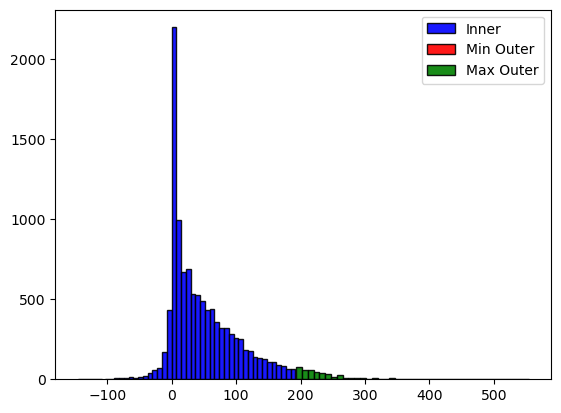

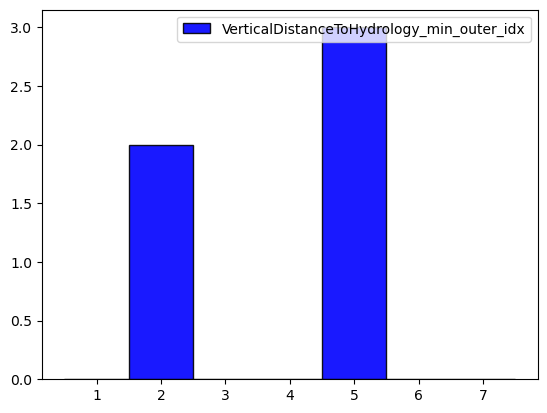

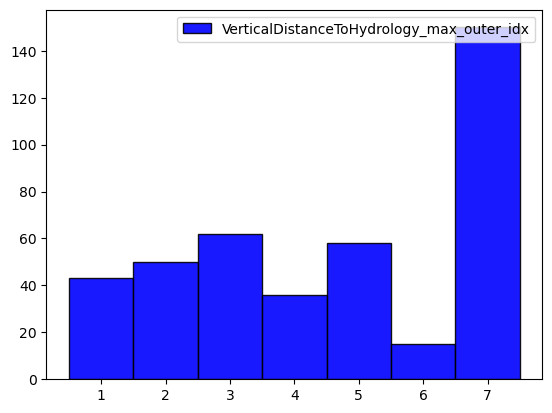

---------------------------------------------------------------------------------------------------
HorizontalDistanceToRoadways : 
N of Min outer : 0
N of Max outer : 620


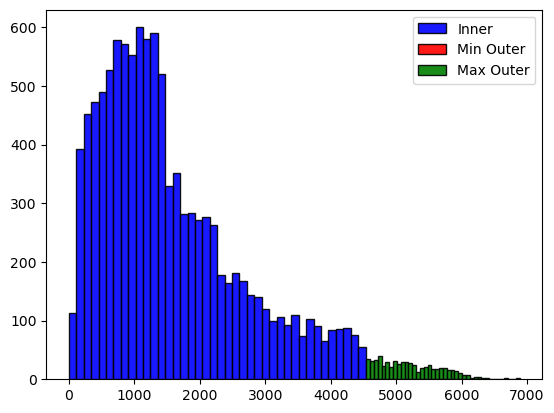

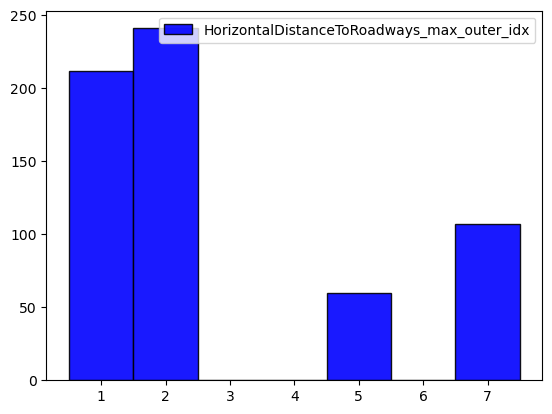

---------------------------------------------------------------------------------------------------
Hillshade9am : 
N of Min outer : 307
N of Max outer : 0


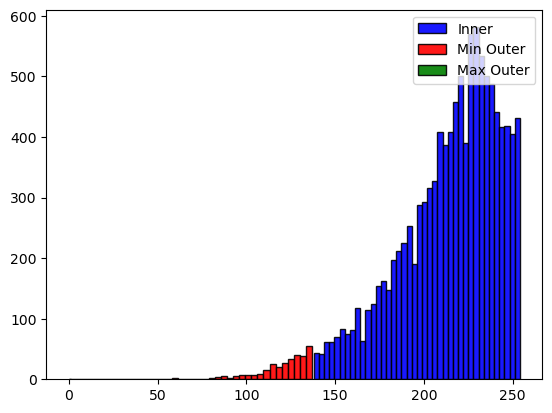

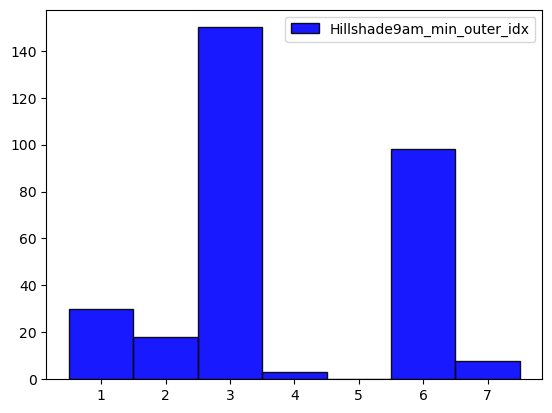

---------------------------------------------------------------------------------------------------
HillshadeNoon : 
N of Min outer : 305
N of Max outer : 0


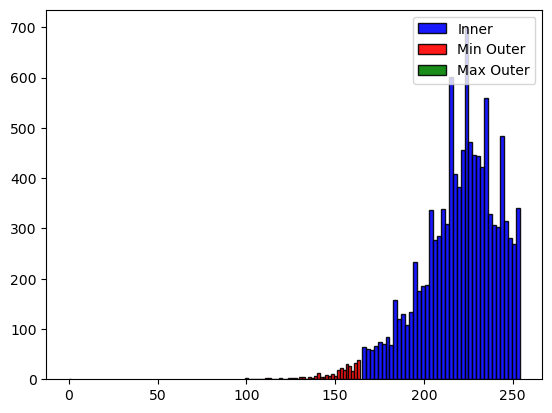

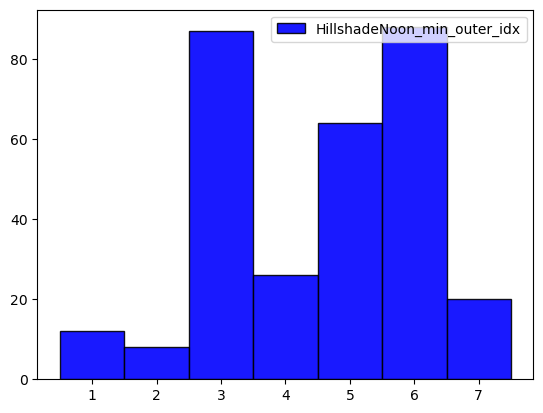

---------------------------------------------------------------------------------------------------
Hillshade3pm : 
N of Min outer : 103
N of Max outer : 0


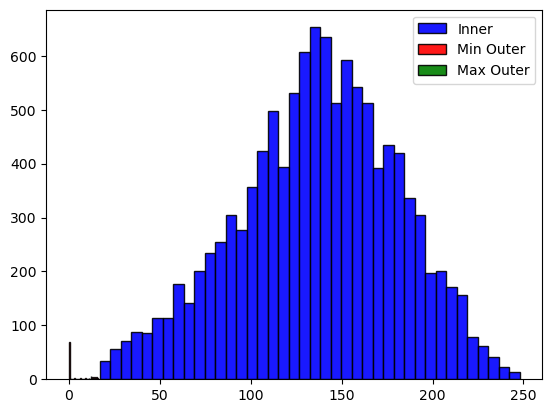

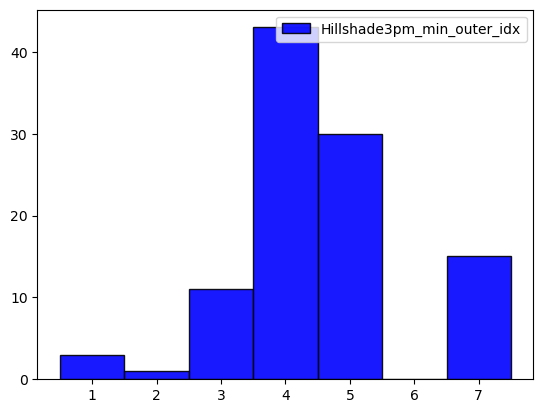

---------------------------------------------------------------------------------------------------
HorizontalDistanceToFirePoints : 
N of Min outer : 0
N of Max outer : 480


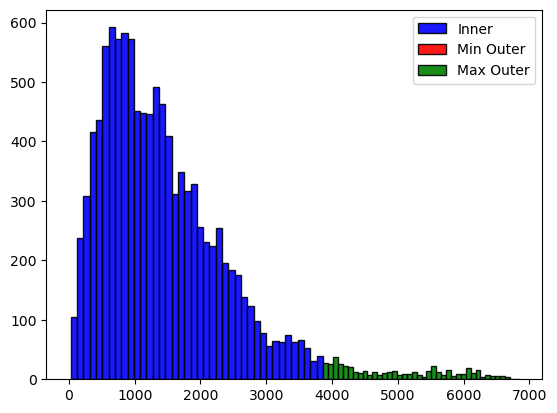

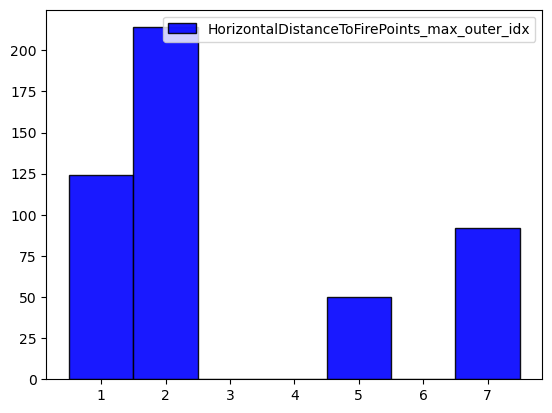

---------------------------------------------------------------------------------------------------
----------------------------------------------------
columns of outer : ['Slope', 'HorizontalDistanceToHydrology', 'VerticalDistanceToHydrology', 'HorizontalDistanceToRoadways', 'Hillshade9am', 'HillshadeNoon', 'Hillshade3pm', 'HorizontalDistanceToFirePoints']
N of outer : 2130


In [12]:
columns_qv = df_input_train_qv.columns

outer_idx = []
outer_colums = []
outer_colums_idx = {}

for c in columns_qv:
    df = df_input_train_qv[c]
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    diff = q3 - q1
    
    r_min = q1 - 1.5*diff
    r_max = q3 + 1.5*diff
    
    df_min_outer = df[df < r_min]
    min_outer_idx = [min_idx for min_idx in df_min_outer.index]
    df_max_outer = df[df > r_max]
    max_outer_idx = [max_idx for max_idx in df_max_outer.index]
    outer_idx += min_outer_idx + max_outer_idx
    
    df_inner = df[r_min <= df]
    df_inner = df_inner[df_inner <= r_max]
    
    print(f"{c} : ")
    print(f"N of Min outer : {len(df_min_outer)}")
    print(f"N of Max outer : {len(df_max_outer)}")
    
    plt.hist(df_inner, bins=40, alpha=0.9, color='blue', label='Inner', edgecolor='black')
    plt.hist(df_min_outer, bins=40, alpha=0.9, color='red', label='Min Outer', edgecolor='black')
    plt.hist(df_max_outer, bins=40, alpha=0.9, color='green', label='Max Outer', edgecolor='black')
    plt.legend(loc='upper right')
    plt.show()
    
    if len(df_min_outer) != 0 or len(df_max_outer) != 0:
        outer_colums.append(c)
        if len(df_min_outer) != 0:
            outer_colums_idx[f"{c}_min_outer_idx"] = min_outer_idx
            plt.hist(df_target_train.iloc[min_outer_idx, 0], bins=7, range=(0.5, 7.5), alpha=0.9, color='blue', label=f'{c}_min_outer_idx', edgecolor='black')
            plt.legend(loc='upper right')
            plt.show()
        if len(df_max_outer) != 0:
            outer_colums_idx[f"{c}_max_outer_idx"] = max_outer_idx
            plt.hist(df_target_train.iloc[max_outer_idx, 0], bins=7, range=(0.5, 7.5), alpha=0.9, color='blue', label=f'{c}_max_outer_idx', edgecolor='black')
            plt.legend(loc='upper right')
            plt.show()

    print(f"---------------------------------------------------------------------------------------------------")
    
# 重複を除去
unique_outer_idx = list(set(outer_idx))
print(f"----------------------------------------------------")
print(f"columns of outer : {outer_colums}")
print(f"N of outer : {len(unique_outer_idx)}")

- 外れ値をもつデータは2,130個.
- Trainデータ11,340個に対して, 2,130個のデータを削除するのは多すぎる.
- ChatGPT (GPT-3.5)に, 「データ分析において、外れ値分析をしたのち、その外れ値を除外する場合、元のデータ数の何％まで除外してもよいですか？」と聞いてみた.
    
    → 
    
    外れ値を除外する際に、元のデータ数の何％まで除外することが適切かどうかは、分析の目的やデータの性質によって異なります。一般的には、以下のような観点から考えることが重要です。

    データの性質による判断
    外れ値を除外する場合には、データの性質に合わせて除外する割合を決めることが重要です。例えば、正規分布に従うデータの場合には、通常は3σ法を用いて、平均値から3σ以上離れた値を外れ値として除外することが一般的です。しかし、非正規分布の場合には、異なる方法が必要になることがあります。

    分析の目的による判断
    分析の目的によっては、外れ値を除外することが適切でない場合があります。例えば、一部の外れ値が分析上重要な情報を含んでいる場合には、除外することで分析結果が歪む可能性があります。

    データの量による判断
    データ数が少ない場合には、外れ値を除外することがデータの偏りを生じる可能性があるため、注意が必要です。一般的には、データ数が多い場合には、外れ値を除外してもデータの偏りが少なくなるため、割合を大きく設定することができます。

    以上の観点から、外れ値を除外する場合には、データの性質や分析の目的に合わせて適切な割合を決めることが重要です。一般的には、データ数が多く、外れ値が明らかに異常値である場合には、10%程度まで除外することができますが、データ数が少ない場合や、外れ値が重要な情報を含んでいる場合には、除外する割合を少なくする必要があります。

In [13]:
# HillShade 3pmの外れ値を0にする
idx = outer_colums_idx["Hillshade3pm_min_outer_idx"]
df_input_train_qv_fix_outer = df_input_train_qv.copy()
df_input_train_qv_fix_outer.iloc[idx] = 0

np_input_train_qv_fix_outer = np.array(df_input_train_qv_fix_outer)

In [38]:
print(f"Random Forest ------------------------------------------------------------")

rfc = RandomForestClassifier(random_state=42)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(rfc, np_input_train_qv_fix_outer, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

# # 収束せず
# print(f"Logistic Regression ------------------------------------------------------------")

# lgr = LogisticRegression(random_state=random_state)

# sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
# sk_fold_scores = cross_val_score(lgr, np_input_train_qv_fix_outer, np_target_train, cv=sk_fold)

# print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
# print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"SVM ------------------------------------------------------------")

svc = SVC(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(svc, np_input_train_qv_fix_outer, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"KNN ------------------------------------------------------------")

knn = KNeighborsClassifier()

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(knn, np_input_train_qv_fix_outer, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"MLP ------------------------------------------------------------")

mlp = MLPClassifier(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(mlp, np_input_train_qv_fix_outer, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

MLP ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.52821869 0.50220459 0.49911817 0.51719577 0.47839506]
Mean Cross Val Score : 0.505026455026455


## VIF (分散拡大係数)
出典 : https://zasshoku-ds.com/multicollinearity/

VIF が5 or 10を超えると対象の説明変数が他の説明変数と高い共線性を持つと認めると記載されている.

In [15]:
def create_vif_df(X):
    # vifを計算
    X = add_constant(X)  # 定数の追加
    df_vif = pd.DataFrame()
    df_vif["features"] = X.columns
    df_vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return df_vif

df_input_train_qv_fix_vif = df_input_train_qv.copy()
vif_bef = create_vif_df(df_input_train_qv_fix_vif)
vif_bef.head(11)

,features,VIF
0,const,3338.958557
1,Elevation,1.911602
2,Aspect,1.902053
3,Slope,8.081970
4,HorizontalDistanceToHydrology,2.236833
5,VerticalDistanceToHydrology,2.089496
6,HorizontalDistanceToRoadways,1.728061
7,Hillshade9am,109.581237
8,HillshadeNoon,41.272509
9,Hillshade3pm,164.103039


In [16]:
# VIFが 10を超える Hillshade9am, HillshadeNoon, Hillshade3pm を除外
df_input_train_qv_fix_vif = df_input_train_qv.copy()
df_input_train_qv_fix_vif = df_input_train_qv_fix_vif.drop(['HillshadeNoon', 'Hillshade3pm'], axis=1)
np_input_train_qv_fix_vif = np.array(df_input_train_qv_fix_vif)
vif_bef = create_vif_df(df_input_train_qv_fix_vif)
vif_bef.head(11)

,features,VIF
0,const,172.992377
1,Elevation,1.906972
2,Aspect,1.569796
3,Slope,1.359704
4,HorizontalDistanceToHydrology,2.232224
5,VerticalDistanceToHydrology,2.088993
6,HorizontalDistanceToRoadways,1.715654
7,Hillshade9am,1.638213
8,HorizontalDistanceToFirePoints,1.408508


In [25]:
print(f"Random Forest ------------------------------------------------------------")

rfc = RandomForestClassifier(random_state=42)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(rfc, np_input_train_qv_fix_vif, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

# # 収束せず
# print(f"Logistic Regression ------------------------------------------------------------")

# lgr = LogisticRegression(random_state=random_state)

# sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
# sk_fold_scores = cross_val_score(lgr, np_input_train_qv_fix_vif, np_target_train, cv=sk_fold)

# print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
# print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"SVM ------------------------------------------------------------")

svc = SVC(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(svc, np_input_train_qv_fix_vif, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"KNN ------------------------------------------------------------")

knn = KNeighborsClassifier()

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(knn, np_input_train_qv_fix_vif, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"MLP ------------------------------------------------------------")

mlp = MLPClassifier(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(mlp, np_input_train_qv_fix_vif, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

Random Forest ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.83862434 0.82451499 0.83068783 0.83201058 0.82716049]
Mean Cross Val Score : 0.830599647266314
SVM ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.65035273 0.62610229 0.63007055 0.62786596 0.63051146]
Mean Cross Val Score : 0.6329805996472663
KNN ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.79232804 0.79100529 0.78747795 0.76719577 0.77865961]
Mean Cross Val Score : 0.7833333333333334
MLP ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.42857143 0.46604938 0.43342152 0.4664903  0.47795414]
Mean Cross Val Score : 0.4544973544973544


## 相関係数行列の可視化

In [17]:
def plot_heatmap(df):
    df_corr = df.corr()
    plt.figure(figsize=(10,10))
    sns.heatmap(df_corr, vmin=-1.0, vmax=1.0, center=0, annot=True, fmt='.2f', xticklabels=df_corr.columns.values, yticklabels=df_corr.columns.values)

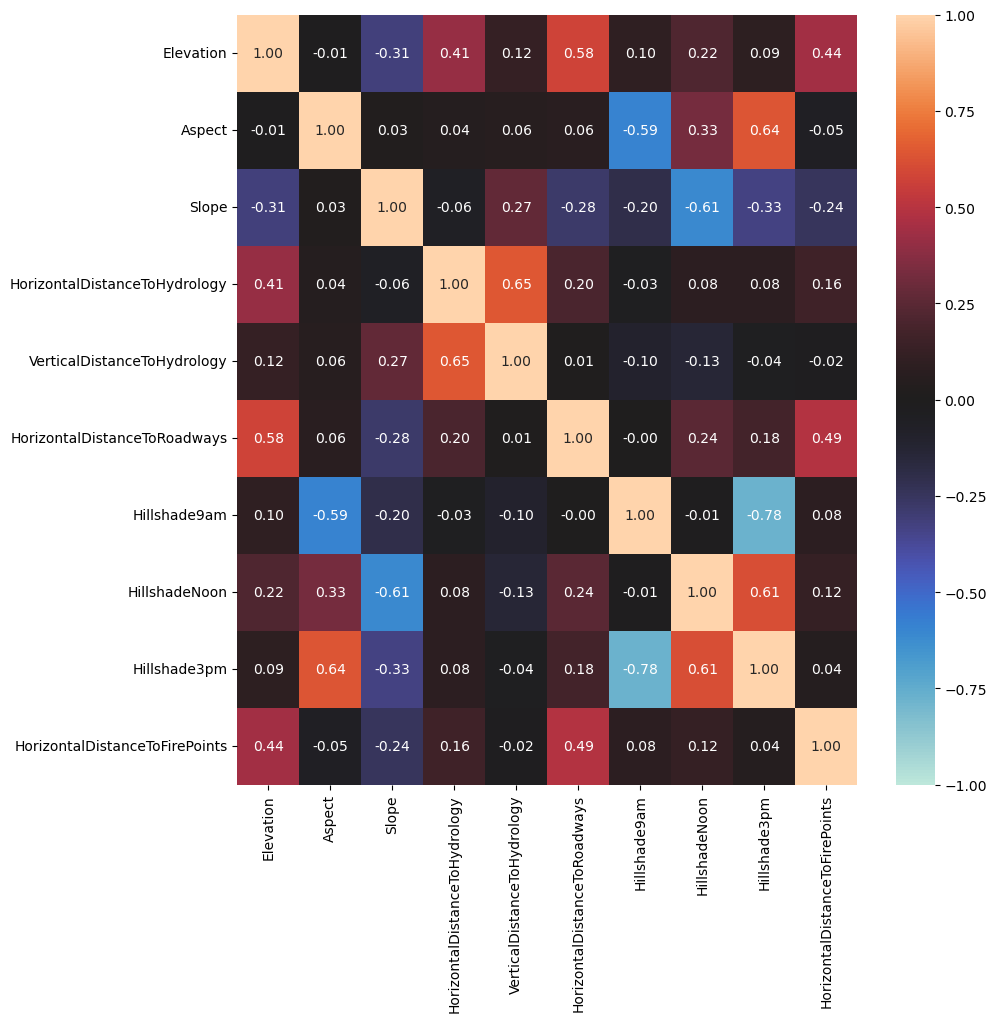

In [18]:
plot_heatmap(df_input_train_qv)

## 説明変数分析(質的変数)

In [19]:
df_input_train_cv = df_input_train.iloc[:, 10:] 
df_input_valid_cv = df_input_valid.iloc[:, 10:]
np_input_train_cv = np.array(df_input_train_cv)
np_input_valid_cv = np.array(df_input_valid_cv)
columns_qv = df_input_train_cv.columns

In [27]:
print(f"Random Forest ------------------------------------------------------------")

rfc = RandomForestClassifier(random_state=42)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(rfc, np_input_train_cv, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

# 収束せず
# print(f"Logistic Regression ------------------------------------------------------------")

# lgr = LogisticRegression(random_state=random_state)

# sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
# sk_fold_scores = cross_val_score(lgr, np_input_train_cv, np_target_train, cv=sk_fold)

# print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
# print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"SVM ------------------------------------------------------------")

svc = SVC(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(svc, np_input_train_cv, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"KNN ------------------------------------------------------------")

knn = KNeighborsClassifier()

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(knn, np_input_train_cv, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"MLP ------------------------------------------------------------")

mlp = MLPClassifier(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(mlp, np_input_train_cv, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

Random Forest ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.59700176 0.60229277 0.58686067 0.58421517 0.58906526]
Mean Cross Val Score : 0.5918871252204585
SVM ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.59744268 0.60229277 0.58686067 0.58377425 0.58906526]
Mean Cross Val Score : 0.5918871252204585
KNN ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.55467372 0.55555556 0.55202822 0.49911817 0.55555556]
Mean Cross Val Score : 0.5433862433862433
MLP ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.60141093 0.60185185 0.5877425  0.58421517 0.58333333]
Mean Cross Val Score : 0.591710758377425


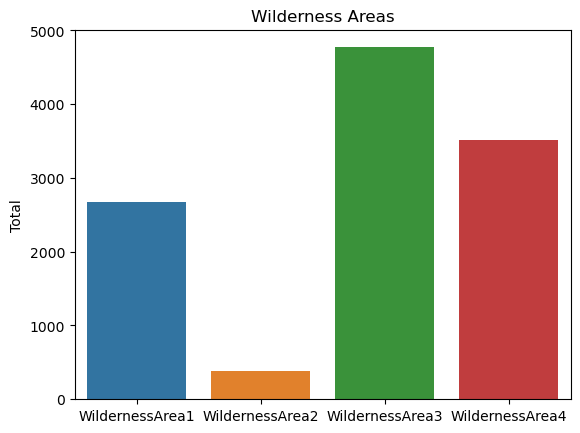

In [20]:
wilderness = df_input_train_cv.iloc[:, :4].sum(axis=0)

plt.figure()
sns.barplot(x=wilderness.index, y=wilderness.values)

plt.xticks()
plt.title('Wilderness Areas')
plt.ylabel('Total')

plt.show()

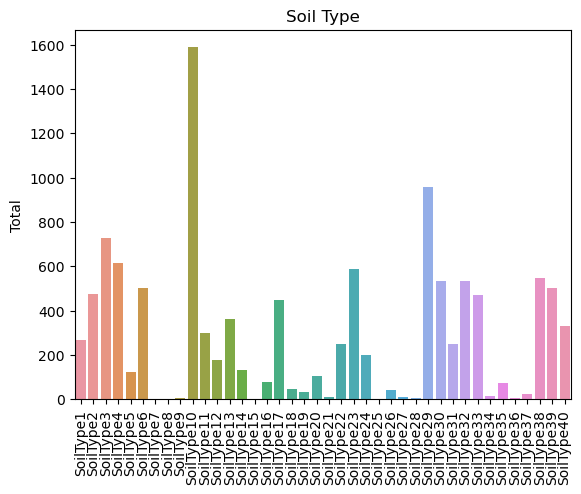

In [21]:
soils = df_input_train_cv.iloc[:, 4:].sum(axis=0)

sns.barplot(x=soils.index, y=soils.values)

plt.xticks(rotation=90)
plt.title('Soil Type')
plt.ylabel('Total')

plt.show()

# 説明変数の決定

- 量的変数および質的変数の分析より, 生データの説明変数に以下の処理を施す.
    - 量的変数の正規化
    - VIFを参考に HillshadeNoon, Hillshade3pm を削除する.
- 正規化の際の最大値および最小値はTrainのものを用いる.

In [23]:
df_input_train_determine = df_input_train.copy()
df_input_train_determine.iloc[:, :10] = norm_minmax(df_input_train_determine.iloc[:, :10])
df_input_train_determine = df_input_train_determine.drop(['HillshadeNoon', 'Hillshade3pm'], axis=1)
np_input_train_determine = np.array(df_input_train_determine)

df_input_valid_determine = df_input_valid.copy()
df_input_valid_determine.iloc[:, :10] = norm_minmax(df_input_valid_determine.iloc[:, :10], df_min=df_input_train.iloc[:, :10].min(), df_max= df_input_train.iloc[:, :10].max())
df_input_valid_determine = df_input_valid_determine.drop(['HillshadeNoon', 'Hillshade3pm'], axis=1)
np_input_valid_determine = np.array(df_input_valid_determine)

df_input_test_determine = df_input_test.copy()
df_input_test_determine.iloc[:, :10] = norm_minmax(df_input_test_determine.iloc[:, :10], df_min=df_input_train.iloc[:, :10].min(), df_max= df_input_train.iloc[:, :10].max())
df_input_test_determine = df_input_test_determine.drop(['HillshadeNoon', 'Hillshade3pm'], axis=1)
np_input_test_determine = np.array(df_input_test_determine)

In [31]:
print(f"Random Forest ------------------------------------------------------------")

rfc = RandomForestClassifier(random_state=42)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(rfc, np_input_train_determine, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

# 収束せず
# print(f"Logistic Regression ------------------------------------------------------------")

# lgr = LogisticRegression(random_state=random_state)

# sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
# sk_fold_scores = cross_val_score(lgr, np_input_train_determine, np_target_train, cv=sk_fold)

# print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
# print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"SVM ------------------------------------------------------------")

svc = SVC(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(svc, np_input_train_determine, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"KNN ------------------------------------------------------------")

knn = KNeighborsClassifier()

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(knn, np_input_train_determine, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

print(f"MLP ------------------------------------------------------------")

mlp = MLPClassifier(random_state=random_state)

sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
sk_fold_scores = cross_val_score(mlp, np_input_train_determine, np_target_train, cv=sk_fold)

print(f"StratifiedKFold Cross Val Score : {sk_fold_scores}")
print(f"Mean Cross Val Score : {np.mean(sk_fold_scores)}")

Random Forest ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.87257496 0.85537919 0.85934744 0.86067019 0.84479718]
Mean Cross Val Score : 0.8585537918871253
SVM ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.6984127  0.70943563 0.68209877 0.68253968 0.69356261]
Mean Cross Val Score : 0.6932098765432098
KNN ------------------------------------------------------------
StratifiedKFold Cross Val Score : [0.79409171 0.78835979 0.78483245 0.7835097  0.76940035]
Mean Cross Val Score : 0.7840388007054674
MLP ------------------------------------------------------------


/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

StratifiedKFold Cross Val Score : [0.77821869 0.76322751 0.76366843 0.76146384 0.7627866 ]
Mean Cross Val Score : 0.7658730158730159


/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## ハイパーパラメータチューニング

In [47]:
n_trials = 100

# Random Forest
def objective(trial):
    
    n_split = 5
    shuffle = True
    random_state=42
    
    n_estimators = trial.suggest_int("n_estimators", 50, 300, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 8)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    
    rfc = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split, criterion=criterion, random_state=random_state)

    sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
    sk_fold_scores = cross_val_score(rfc, np_input_train_determine, np_target_train, cv=sk_fold)
    
    return 1.0 - np.mean(sk_fold_scores)

study_rfc = optuna.create_study()
study_rfc.optimize(objective, n_trials = n_trials)

In [50]:
print(f"best params : {study_rfc.best_params}\nbest score : {1 - study_rfc.best_value}")

best params : {'n_estimators': 250, 'min_samples_split': 2, 'criterion': 'entropy'}
best score : 0.8607583774250441


In [64]:
# SVM
def objective(trial):
    
    n_split = 5
    shuffle = True
    random_state=42
    
    C = trial.suggest_float("C", 1e-3, 1e+3)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    
    svc = SVC(C=C, kernel=kernel, gamma=gamma, random_state=random_state)

    sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
    sk_fold_scores = cross_val_score(svc, np_input_train_determine, np_target_train, cv=sk_fold)
    
    return 1.0 - np.mean(sk_fold_scores)

study_svc = optuna.create_study()
study_svc.optimize(objective, n_trials = n_trials)

In [58]:
print(f"best params : {study_svc.best_params}\nbest score : {1 - study_svc.best_value}")

best params : {'C': 926.0602500128075, 'kernel': 'rbf', 'gamma': 'scale'}
best score : 0.8154320987654323


In [63]:
# KNN
def objective(trial):
    
    n_split = 5
    shuffle = True
    random_state=42
    
    n_neighbors = trial.suggest_int("n_neighbors", 1, 20)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

    sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
    sk_fold_scores = cross_val_score(knn, np_input_train_determine, np_target_train, cv=sk_fold)
    
    return 1.0 - np.mean(sk_fold_scores)

study_knn = optuna.create_study()
study_knn.optimize(objective, n_trials = n_trials)

In [60]:
print(f"best params : {study_knn.best_params}\nbest score : {1 - study_knn.best_value}")

best params : {'n_neightbors': 1, 'weights': 'distance'}
best score : 0.8187830687830688


In [69]:
# MLP
def objective(trial):
    
    n_split = 5
    shuffle = True
    random_state=42
    
    activation = trial.suggest_categorical("activation", ["logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["sgd", "adam"])
    lr = trial.suggest_categorical("lr", ["constant", "invscaling", "adaptive"])
    lr_init = trial.suggest_uniform("lr_init", 1e-4, 1e-2)
    
    mlp = MLPClassifier(activation=activation, solver=solver, learning_rate=lr, learning_rate_init=lr_init, random_state=random_state)

    sk_fold = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
    sk_fold_scores = cross_val_score(mlp, np_input_train_determine, np_target_train, cv=sk_fold)
    
    return 1.0 - np.mean(sk_fold_scores)

study_mlp = optuna.create_study()
study_mlp.optimize(objective, n_trials = n_trials)

In [68]:
print(f"best params : {study_mlp.best_params}\nbest score : {1 - study_mlp.best_value}")

best params : {'activation': 'relu', 'solver': 'adam', 'lr': 'constant', 'lr_init': 0.005711924189203709}
best score : 0.8098765432098766


## チューニングしたハイパーパラメータを用いて Test データのスコアを測定

In [25]:
print(f"Random Forest ------------------------------------------------------------")
rfc = RandomForestClassifier(n_estimators=250, min_samples_split=2, criterion="entropy", random_state=random_state)
rfc.fit(np_input_train_determine, np_target_train)
scores = rfc.score(np_input_test_determine, np_target_test)

print(f"score : {scores}")

# print(f"Logistic Regression ------------------------------------------------------------")
# lgr = LogisticRegression(random_state=random_state)
# lgr.fit(np_input_train_determine, np_target_train)
# scores = lgr.score(np_input_test_determine, np_target_test)

# print(f"score : {scores}")

print(f"SVM ------------------------------------------------------------")
svc = SVC(C=926, kernel="rbf", gamma="scale", random_state=random_state)
svc.fit(np_input_train_determine, np_target_train)
scores = svc.score(np_input_test_determine, np_target_test)

print(f"score : {scores}")

print(f"KNN ------------------------------------------------------------")
knn = KNeighborsClassifier(n_neighbors=1, weights="distance")
knn.fit(np_input_train_determine, np_target_train)
scores = knn.score(np_input_test_determine, np_target_test)

print(f"score : {scores}")

print(f"MLP ------------------------------------------------------------")
mlp = MLPClassifier(activation="relu", solver="adam", learning_rate="constant", learning_rate_init=0.0057, random_state=random_state)
mlp.fit(np_input_train_determine, np_target_train)
scores = mlp.score(np_input_test_determine, np_target_test)

print(f"score : {scores}")

Random Forest ------------------------------------------------------------
score : 0.7420232129098838
SVM ------------------------------------------------------------
score : 0.6965922826263669
KNN ------------------------------------------------------------
score : 0.6966612003703887
MLP ------------------------------------------------------------


/home/nakaya-shunsuke/.conda/envs/ds/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


score : 0.6887444954160865


## Train, Valid, Test の割合を変更し, Testに対するスコアを測定

- Train, Valid, Test = (406708, 87152, 87152)の割合で分割する.
- Train, Valid, Test = (70%, 15%, 15%)に相当.

In [12]:
df_input_shuffle = df_input.sample(frac=1, random_state=random_state, ignore_index=True)
df_target_shuffle  = df_target.sample(frac=1, random_state=random_state, ignore_index=True)

df_input_shuffle_train = df_input_shuffle.iloc[:406708]
df_target_shuffle_train = df_target_shuffle.iloc[:406708]
np_input_shuffle_train = np.array(df_input_shuffle_train)
np_target_shuffle_train = np.array(df_target_shuffle_train).reshape(-1)

df_input_shuffle_valid = df_input_shuffle.iloc[406708:406708+87152]
df_target_shuffle_valid = df_target_shuffle.iloc[406708:406708+87152]
np_input_shuffle_valid = np.array(df_input_shuffle_valid)
np_target_shuffle_valid = np.array(df_target_shuffle_valid).reshape(-1)

df_input_shuffle_test = df_input_shuffle.iloc[406708+87152:]
df_target_shuffle_test = df_target_shuffle.iloc[406708+87152:]
np_input_shuffle_test = np.array(df_input_shuffle_test)
np_target_shuffle_test = np.array(df_target_shuffle_test).reshape(-1)

In [13]:
# 正規化と不要な特徴量の削除

df_input_shuffle_train_determine = df_input_shuffle_train.copy()
df_input_shuffle_train_determine.iloc[:, :10] = norm_minmax(df_input_shuffle_train_determine.iloc[:, :10])
df_input_shuffle_train_determine = df_input_shuffle_train_determine.drop(['HillshadeNoon', 'Hillshade3pm'], axis=1)
np_input_shuffle_train_determine = np.array(df_input_shuffle_train_determine)

df_input_shuffle_valid_determine = df_input_shuffle_valid.copy()
df_input_shuffle_valid_determine.iloc[:, :10] = norm_minmax(df_input_shuffle_valid_determine.iloc[:, :10], df_min=df_input_shuffle_train.iloc[:, :10].min(), df_max= df_input_shuffle_train.iloc[:, :10].max())
df_input_shuffle_valid_determine = df_input_shuffle_valid_determine.drop(['HillshadeNoon', 'Hillshade3pm'], axis=1)
np_input_shuffle_valid_determine = np.array(df_input_shuffle_valid_determine)

df_input_shuffle_test_determine = df_input_shuffle_test.copy()
df_input_shuffle_test_determine.iloc[:, :10] = norm_minmax(df_input_shuffle_test_determine.iloc[:, :10], df_min=df_input_shuffle_train.iloc[:, :10].min(), df_max= df_input_shuffle_train.iloc[:, :10].max())
df_input_shuffle_test_determine = df_input_shuffle_test_determine.drop(['HillshadeNoon', 'Hillshade3pm'], axis=1)
np_input_shuffle_test_determine = np.array(df_input_shuffle_test_determine)

In [1]:
print(f"Random Forest ------------------------------------------------------------")
rfc = RandomForestClassifier(n_estimators=250, min_samples_split=2, criterion="entropy", random_state=random_state)
rfc.fit(np_input_shuffle_train_determine, np_target_shuffle_train)
scores = rfc.score(np_input_shuffle_test_determine, np_target_shuffle_test)

print(f"score : {scores}")

# print(f"Logistic Regression ------------------------------------------------------------")
# lgr = LogisticRegression(random_state=random_state)
# lgr.fit(np_input_shuffle_train_determine, np_target_shuffle_train)
# scores = lgr.score(np_input_shuffle_test_determine, np_target_shuffle_test)

# print(f"score : {scores}")

print(f"SVM ------------------------------------------------------------")
svc = SVC(C=926, kernel="rbf", gamma="scale", random_state=random_state)
svc.fit(np_input_shuffle_train_determine, np_target_shuffle_train)
scores = svc.score(np_input_shuffle_test_determine, np_target_shuffle_test)

print(f"score : {scores}")

print(f"KNN ------------------------------------------------------------")
knn = KNeighborsClassifier(n_neighbors=1, weights="distance")
knn.fit(np_input_shuffle_train_determine, np_target_shuffle_train)
scores = knn.score(np_input_shuffle_test_determine, np_target_shuffle_test)

print(f"score : {scores}")

print(f"MLP ------------------------------------------------------------")
mlp = MLPClassifier(activation=activation, solver=solver, learning_rate=lr, learning_rate_init=lr_init, random_state=random_state)
mlp.fit(np_input_shuffle_train_determine, np_target_shuffle_train)
scores = mlp.score(np_input_shuffle_test_determine, np_target_shuffle_test)

print(f"score : {scores}")